# Training

> This defines the parameter fitting (or to use the ML term training loop) for our ode models. It also shows how to organize your data into a Dataset and dataloader in pytorch. 

In [ ]:
#| default_exp training


In [ ]:
#| export 
import torch 
import torch.nn as nn
from torchdiffeq import odeint
import pylab as plt
from torch.utils.data import Dataset, DataLoader
from typing import Callable, List, Tuple, Union, Optional
from paramfittorchdemo.models import *

In [ ]:
#| exports 

class SimODEData(Dataset):
    """ 
        A very simple dataset class for simulating ODEs, really could just use
        a tensor of the values directly but for general use it is very nice to
        define a Dataset class for your data. This can handle batching and 
        other nice things.
    """
    def __init__(self,
                 ts: List[torch.Tensor], # List of time points
                 values: List[torch.Tensor], # List of dynamical state values at each time point 
                 ) -> None:
        self.ts = ts 
        self.values = values 
        
    def __len__(self) -> int:
        return len(self.ts)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.ts[index], self.values[index]

      

In [ ]:

#| export 

def create_sim_dataset(model: nn.Module, # model to simulate from
                       ts: torch.Tensor, # Time points to simulate at
                       num_samples: int = 10, # Number of samples to generate
                       sigma_noise: float = 0.1, # Noise level to add to the data
                       initial_conditions_default: torch.Tensor = torch.tensor([0.0, 0.0]), # Default initial conditions
                       sigma_initial_conditions: float = 0.1, # Noise level to add to the initial conditions
                       ) -> SimODEData:
    ts_list = [] 
    states_list = [] 
    for i in range(num_samples):
        x0 = sigma_initial_conditions * torch.randn((1,2)).detach() + initial_conditions_default
        ys = odeint(model, x0, ts).squeeze(1).detach() 
        ys += sigma_noise*torch.randn_like(ys)
        ts_list.append(ts)
        states_list.append(ys)
    return SimODEData(ts_list, states_list)
    


In [ ]:

#| exports

def train(model: torch.nn.Module, 
          data: SimODEData, 
          lr: float = 1e-2, 
          epochs: int = 10):
    trainloader = DataLoader(data, batch_size=5, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs):
        running_loss = 0.0 
        for data in trainloader:
            optimizer.zero_grad()
            ts, states = data 
            initial_state = states[:,0,:]
            pred = odeint(model, initial_state, ts[0]).transpose(0,1)
            loss = criterion(pred, states)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Loss at {epoch}: {running_loss}")



## Fitting the VDP Oscillator

Let's use this training loop to recover the parameters from simulated VDP oscillator data

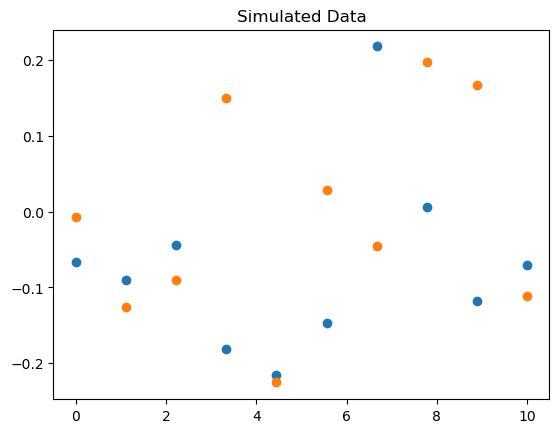

In [ ]:
true_mu = 0.30
model_sim = VDP(mu=true_mu)
ts_data = torch.linspace(0.0,10.0,10) 
data_vdp = create_sim_dataset(model_sim, 
                              ts = ts_data, 
                              num_samples=10, 
                              sigma_noise=0.1)
_, y_data = data_vdp[0] 
plt.scatter(ts_data, y_data[:,0]);
plt.scatter(ts_data, y_data[:,1]);
plt.title("Simulated Data");

The starting point:  mu: 0.10000000149011612


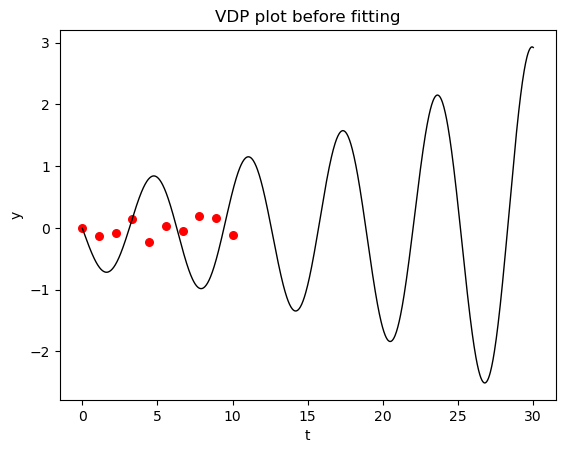

In [ ]:

vdp_model = VDP(mu = 0.10) 
print(f"The starting point: {vdp_model}")   

ts = torch.linspace(0,30.0,1000)
ts_data, y_data = data_vdp[0]
initial_conditions = y_data[0, :].unsqueeze(0)
sol = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()


# Check the solution
plt.plot(ts, sol[:,:,1], color='black', lw=1.0);
plt.scatter(ts_data, y_data[:,1], color='red', s=30);
plt.title("VDP plot before fitting");
plt.xlabel("t");
plt.ylabel("y");



In [ ]:

train(vdp_model, data_vdp, epochs=40)
print(f"After training: {vdp_model}, where the true value is {true_mu}")
print(f"Error: {vdp_model.mu - true_mu}")


Loss at 0: 1.1857575476169586
Loss at 10: 0.46942032873630524
Loss at 20: 0.4495031386613846
Loss at 30: 0.44933897256851196
After training:  mu: 0.2727024555206299, where the true value is 0.3
Error: -0.027297556400299072


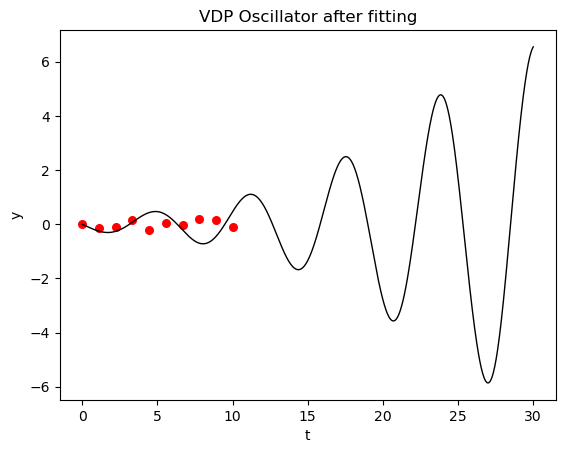

In [ ]:

sol_after_fitting = odeint(vdp_model, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(ts, sol_after_fitting[:,:,1], color='black', lw=1.0);
plt.scatter(ts_data, y_data[:,1], color='red', s=30);
plt.title("VDP Oscillator after fitting");
plt.xlabel("t");
plt.ylabel("y");

## Fitting the Lotka Voltera Equations 

Now lets adapt our methods to fit simulated data from the Lotka Voltera equations. 

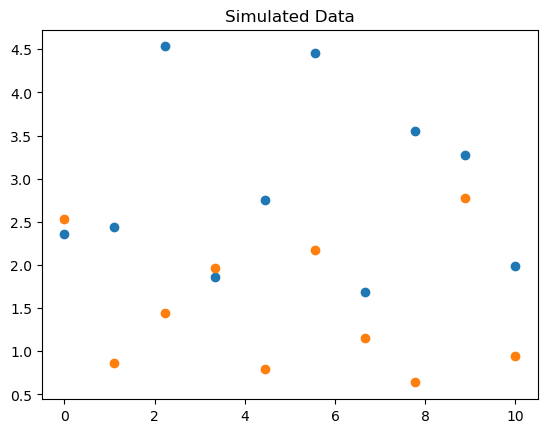

In [ ]:

model_sim_lv = LotkaVolterra()
ts_data = torch.linspace(0.0,10.0,10) 
data_lv = create_sim_dataset(model_sim_lv, 
                              ts = ts_data, 
                              num_samples=1, 
                              sigma_noise=0.1,
                              initial_conditions_default=torch.tensor([2.5, 2.5]))
_, y_data = data_lv[0] 
plt.scatter(ts_data, y_data[:,0]);
plt.scatter(ts_data, y_data[:,1]);
plt.title("Simulated Data");

In [ ]:
model_lv = LotkaVolterra(alpha=1.6, beta=1.1,delta=2.7, gamma=1.2)
train(model_lv, data_lv, epochs=40)
print(f"Fitted model: {model_lv}")
print(f"True model: {model_sim_lv}")

Loss at 0: 0.011727926321327686
Loss at 10: 0.009199537336826324
Loss at 20: 0.008964814245700836
Loss at 30: 0.008998898789286613
Fitted model:  alpha: 1.4918429851531982, beta: 1.0121153593063354, delta: 3.0134477615356445, gamma: 0.9995511174201965
True model:  alpha: 1.5, beta: 1.0, delta: 3.0, gamma: 1.0


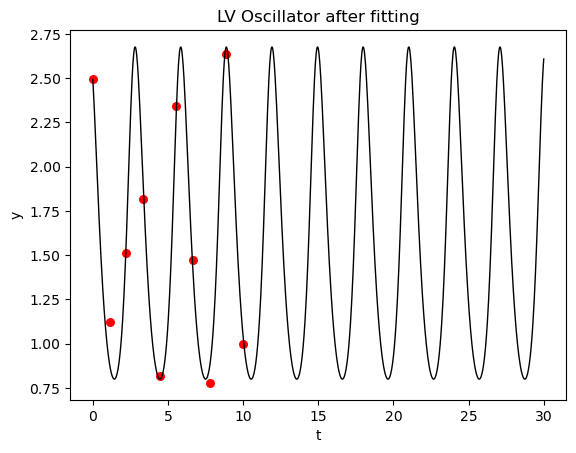

In [ ]:
initial_conditions = y_data[0, :].unsqueeze(0)
sol_after_fitting = odeint(model_lv, initial_conditions, ts, method='dopri5').detach().numpy()

# Check the solution
plt.plot(ts, sol_after_fitting[:,:,1], color='black', lw=1.0);
plt.scatter(ts_data, y_data[:,1], color='red', s=30);
plt.title("LV Oscillator after fitting");
plt.xlabel("t");
plt.ylabel("y");

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()